In [1]:
import acl
import numpy as np
import struct
from constant import NPY_BYTE
from PIL import Image
from postprocessing import estimate_paf, draw_humans
from acl_sample import Sample
from constant import ACL_MEMCPY_DEVICE_TO_HOST

In [3]:
sample = Sample(0,
                "../acl_dvpp_yolov3/model/yolov3_tf.om",
                416,
                416)

[Sample] init resource stage:
[Sample] init resource stage success
[Model] class Model init resource stage:
model output size 3
output  0
model output dims ({'name': 'yolov3/yolov3_head/feature_map_1:0', 'dimCount': 4, 'dims': [1, 13, 13, 255]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'yolov3/yolov3_head/feature_map_2:0', 'dimCount': 4, 'dims': [1, 26, 26, 255]}, 0)
model output datatype 0
output  2
model output dims ({'name': 'yolov3/yolov3_head/feature_map_3:0', 'dimCount': 4, 'dims': [1, 52, 52, 255]}, 0)
model output datatype 0
[Model] create model output dataset:
[Model] create model output dataset success
[Model] class Model init resource stage success


In [15]:
img_dict = {"path": "./data/p3.jpg", "dtype": np.uint8}

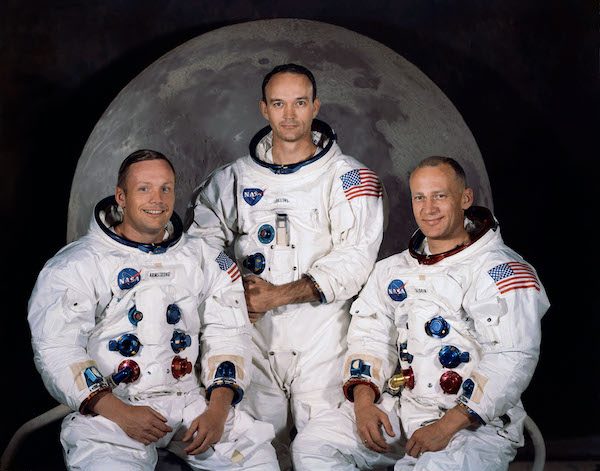

In [16]:
Image.open(img_dict["path"])

In [ ]:
# %timeit -n 100 -r 5 
model_output = sample.forward(img_dict)

In [18]:
acl.mdl.get_dataset_num_buffers(model_output)

3

In [19]:
num_output = acl.mdl.get_dataset_num_buffers(model_output)

def get_model_output_by_index(model_output, i):
    temp_output_buf = acl.mdl.get_dataset_buffer(model_output, i)

    infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
    infer_output_size = acl.get_data_buffer_size(temp_output_buf)
#     print("infer_output_size", infer_output_size)
    
    output_host, _ = acl.rt.malloc_host(infer_output_size)
    acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                          infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)
    
    result = acl.util.ptr_to_numpy(output_host, (infer_output_size,), NPY_BYTE)
    return np.array(struct.unpack(f"{infer_output_size//4}f", bytearray(result)), dtype=np.float32).reshape(92, 92, -1)

In [20]:
peaks = get_model_output_by_index(model_output, 0)
heatmat = get_model_output_by_index(model_output, 1)
pafmat = get_model_output_by_index(model_output, 2)

In [21]:
humans = estimate_paf(peaks, heatmat, pafmat)

In [23]:
img = draw_humans(np.array(Image.open(img_dict["path"])), humans)

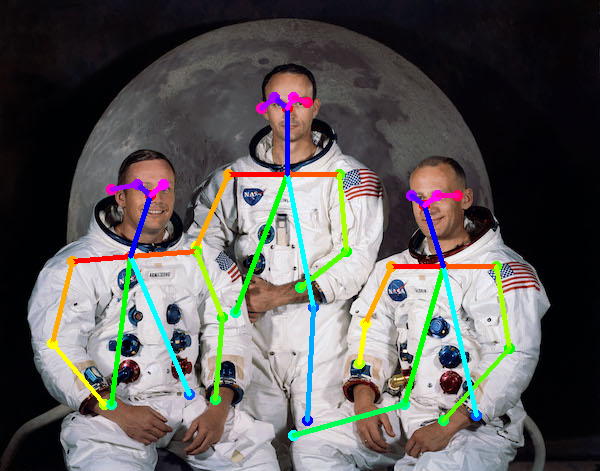

In [24]:
Image.fromarray(img)